# Yelp Review Analysis based on Useful, Funny and Cool Counts

The first step in our process is to import the data in order to analyse the dataset. We beleive that analysing the data before preparing the model is an important aspect of any Machine Learning Task. Please provide the location of the Yelp DataSet in the input box below after which we will extract the reviews that are stricly related to restaurants.


In [1]:
!pip install gensim
!pip install keras
!pip install nltk
!pip install numpy
!pip install pandas
!pip install sklearn
!pip install tensorflow==1.15
!pip install wordcloud

import gensim
from gensim.models import word2vec
from itertools import cycle
import json
from keras.utils import np_utils
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree
from sklearn.preprocessing import LabelEncoder
import sys
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, Dense, Embedding, SimpleRNN, LSTM
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.externals import joblib
import math

nltk.download('all')

Using TensorFlow backend.
/usr/local/Cellar/python/3.7.5/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/kldsouza/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/kldsouza/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /Users/kldsouza/nltk_da

[nltk_data]    |   Package reuters is already up-to-date!
[nltk_data]    | Downloading package rte to
[nltk_data]    |     /Users/kldsouza/nltk_data...
[nltk_data]    |   Package rte is already up-to-date!
[nltk_data]    | Downloading package semcor to
[nltk_data]    |     /Users/kldsouza/nltk_data...
[nltk_data]    |   Package semcor is already up-to-date!
[nltk_data]    | Downloading package senseval to
[nltk_data]    |     /Users/kldsouza/nltk_data...
[nltk_data]    |   Package senseval is already up-to-date!
[nltk_data]    | Downloading package sentiwordnet to
[nltk_data]    |     /Users/kldsouza/nltk_data...
[nltk_data]    |   Package sentiwordnet is already up-to-date!
[nltk_data]    | Downloading package sentence_polarity to
[nltk_data]    |     /Users/kldsouza/nltk_data...
[nltk_data]    |   Package sentence_polarity is already up-to-date!
[nltk_data]    | Downloading package shakespeare to
[nltk_data]    |     /Users/kldsouza/nltk_data...
[nltk_data]    |   Package shakespeare

True

**Please enter the path to the dataset folder below after running the next cell! On running the cell a text input box will appear **

In [3]:
from IPython.display import display
from ipywidgets import widgets
text = widgets.Text()
display(text)

dataset_folder = '/Users/kldsouza/Documents/CS 544/code/project'

def handle_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global dataset_folder
        dataset_folder = change['new']
        print(dataset_folder)

text.observe(handle_change)


Text(value='')

/Users/kldsouza/Documents/CS 544/code/project
/Users/kldsouza/Documents/CS 544/code/project/
/Users/kldsouza/Documents/CS 544/code/project/y
/Users/kldsouza/Documents/CS 544/code/project/ye
/Users/kldsouza/Documents/CS 544/code/project/yel
/Users/kldsouza/Documents/CS 544/code/project/yelp
/Users/kldsouza/Documents/CS 544/code/project/yelp_
/Users/kldsouza/Documents/CS 544/code/project/yelp_d
/Users/kldsouza/Documents/CS 544/code/project/yelp_da
/Users/kldsouza/Documents/CS 544/code/project/yelp_dat
/Users/kldsouza/Documents/CS 544/code/project/yelp_data
/Users/kldsouza/Documents/CS 544/code/project/yelp_datas
/Users/kldsouza/Documents/CS 544/code/project/yelp_datase
/Users/kldsouza/Documents/CS 544/code/project/yelp_dataset


## Data Extraction
In the following cells, we extract data from the review.json and business.json files. The main data that we will work with is the review text for each review along with its count for 'useful', 'funny' and cool.

In [4]:
# functions for data extraction
def extract_data(business_data_folder, review_data_folder):
    output_data = {}
    with open(business_data_folder) as bd_handle:
        business = bd_handle.readline()

        while business:
            bd_data = json.loads(business)

            if bd_data['categories']:
                output_data[bd_data['business_id']] = {
                    'categories': [cat.strip() for cat in bd_data['categories'].split(',')],
                    'reviews': []
                }

            business = bd_handle.readline()

        bd_handle.close()

    with open(review_data_folder) as rd_handle:
        review = rd_handle.readline()

        while review:
            rv_data = json.loads(review)

            if rv_data['business_id'] in output_data:
                review = {}
                review['review_id'] = rv_data['review_id']
                review['text'] = rv_data['text']
                review['useful'] = rv_data['useful']
                review['funny'] = rv_data['funny']
                review['cool'] = rv_data['cool']
                output_data[rv_data['business_id']]['reviews'].append(review)

            review = rd_handle.readline()

        bd_handle.close()
        
    return output_data

def write_extracted_data(output_data, output_file):
    data_to_write = []
    for business_id in output_data:
        categories = output_data[business_id]['categories']

        if 'Restaurants' in categories and len(output_data[business_id]['reviews']) > 0:
            cat_to_write = ':'.join(categories)
            for review in output_data[business_id]['reviews']:
                review_id = review['review_id']
                text = review['text']
                useful = str(review['useful'])
                funny = str(review['funny'])
                cool = str(review['cool'])
                data_to_write.append({
                    'business_id': business_id,
                    'categories': cat_to_write,
                    'review_id': review_id,
                    'text': text,
                    'useful': useful,
                    'funny': funny,
                    'cool': cool
                })           

    with open(output_file, 'w') as of_handle:
        json.dump(data_to_write, of_handle)
        of_handle.close()

In [5]:
business_data_folder = os.path.join(dataset_folder, 'business.json')
review_data_folder = os.path.join(dataset_folder, 'review.json')
output_data = extract_data(business_data_folder, review_data_folder)
dataset_file = './dataset.json'
write_extracted_data(output_data, dataset_file)

Now, the data we need from review.json and business.json are stored in the file "dateset.json". Next, we will clean up the data and write the preprocessed datasets to "normalised_data.json".

## Data Analysis and Cleansing:

In the next cell, we analyse the data, specifically the distribution of values within the 'useful', 'funny' and 'cool' columns. We notice that the data is heavily skewed towards values of 0 and 1. Most of the values for 'useful', 'funny' and 'cool' lie between 0 and 20. There are outliers that occur in the data with some values going up to more than 500. 

In order to enable our model to accurately predict how 'useful', 'funny' or 'cool' a certain review is, we apply feature clipping on each of these columns. We also normalised these values so that they lie in the range of 0 to 1.

In [6]:
# functions for data preprocessing
def preprocess_data(data_file):

    df = pd.read_json(data_file)
    df['useful'] = df['useful'].astype(float)
    df['funny'] = df['funny'].astype(float)
    df['cool'] = df['cool'].astype(float)
    print("Dataset size: {0:d} rows x {1:d} columns".format(df.shape[0], df.shape[1]))

    vote_labels = ['useful', 'funny', 'cool']
    useful_min, useful_max = df['useful'].min(), df['useful'].max()
    funny_min, funny_max = df['funny'].min(), df['funny'].max()
    cool_min, cool_max = df['cool'].min(), df['cool'].max()

    # print out distribution of reviews by their vote counts
    for i in range(len(vote_labels)):
        ranges = np.arange(-1, 100, 10)
        counts = df.groupby(pd.cut(df[vote_labels[i]], ranges)).count()[vote_labels[i]]
        print(counts)
        print("Out of range counts: ", df.shape[0]-counts.sum())

    # save raw vote counts
    df['useful_raw'] = df['useful']
    df['funny_raw'] = df['funny']
    df['cool_raw'] = df['cool']
    # clip vote counts to specific ranges
    df['useful'] = df['useful'].clip(3.0, 27.0)
    df['funny'] = df['funny'].clip(3.0, 20.0)
    df['cool'] = df['cool'].clip(3.0, 24.0)

    # normalize data with min-max scaling
    min_max_scaler = preprocessing.MinMaxScaler()
    useful_scaled = min_max_scaler.fit_transform(np.array(df['useful']).reshape(-1,1))
    df['useful'] = pd.DataFrame(useful_scaled)
    funny_scaled = min_max_scaler.fit_transform(np.array(df['funny']).reshape(-1,1))
    df['funny'] = pd.DataFrame(funny_scaled)
    cool_scaled = min_max_scaler.fit_transform(np.array(df['cool']).reshape(-1,1))
    df['cool'] = pd.DataFrame(cool_scaled)

    ranges = [-0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    processed_data = []

    # balance dataset for each of vote category
    # make sure there is an even number of reviews in each increment of 0.1
    # from range 0.0 to 1.0
    for i in range(len(vote_labels)):
        counts = df.groupby(pd.cut(df[vote_labels[i]], ranges)).count()[vote_labels[i]]
        min_count = counts.min()
        new_df = pd.DataFrame()
        for j in range(10):
            lower = j/10
            upper = (j+1)/10 if j < 9 else 1.1
            new_data = df[(df[vote_labels[i]] >= lower) & (df[vote_labels[i]] < upper)]
            new_data = new_data.sample(frac=1)
            new_data = new_data.head(min_count)
            new_df = new_df.append(new_data)

        processed_data.append(new_df)
    
    return processed_data


def write_extracted_data(useful, funny, cool):
    output_dict = {
        'useful': useful.to_json(orient = 'records'),
        'funny': funny.to_json(orient = 'records'),
        'cool': cool.to_json(orient = 'records')
    }

    with open('normalised_data.json', 'w') as op_handle:
        json.dump(output_dict, op_handle)
        op_handle.close()

In [7]:
processed_data = preprocess_data(dataset_file)
write_extracted_data(processed_data[0], processed_data[1], processed_data[2])

Dataset size: 4201684 rows x 7 columns
useful
(-1, 9]     4148278
(9, 19]       40402
(19, 29]       7225
(29, 39]       2674
(39, 49]       1197
(49, 59]        623
(59, 69]        415
(69, 79]        245
(79, 89]        153
(89, 99]        119
Name: useful, dtype: int64
Out of range counts:  353
funny
(-1, 9]     4180159
(9, 19]       15647
(19, 29]       3281
(29, 39]       1236
(39, 49]        564
(49, 59]        282
(59, 69]        159
(69, 79]         89
(79, 89]         52
(89, 99]         41
Name: funny, dtype: int64
Out of range counts:  174
cool
(-1, 9]     4173089
(9, 19]       20001
(19, 29]       4550
(29, 39]       1778
(39, 49]        913
(49, 59]        477
(59, 69]        316
(69, 79]        179
(79, 89]        134
(89, 99]         95
Name: cool, dtype: int64
Out of range counts:  152


## Word2Vec Model:

In the next step, we cleanse each review by removing any punctuation, full stops and extra spaces. We also lowercase all the words in the review and remove any stopwords from the data. We then use this cleansed dataset to train a Word2Vec model

In [8]:
# functions for creating the word2vec model
def read_data(dataset_file):
    logging.info("Reading data...")
    with open(dataset_file, 'r') as fh:
        full_data = json.load(fh)
        useful_data = pd.DataFrame(json.loads(full_data['useful']))
        funny_data = pd.DataFrame(json.loads(full_data['funny']))
        cool_data = pd.DataFrame(json.loads(full_data['cool']))
        all_data = useful_data.append([funny_data, cool_data])
    
    return useful_data, funny_data, cool_data, all_data


def clean_data(tokenized_data_file, all_data, tokenizer, stop_words):
    logging.info("Cleaning data...")
    with open(tokenized_data_file, 'w') as fh:
        reviews = all_data['text'].tolist()

        for index in range(len(reviews)):
            review = reviews[index]
            no_tabs = str(review).replace('\t', ' ').replace('\n', '')
            alphas_only = re.sub("[^a-zA-Z\.]", " ", no_tabs)
            multi_spaces = re.sub(" +", " ", alphas_only)
            no_spaces = multi_spaces.strip()
            clean_text = no_spaces.lower()
            sentences = tokenizer.tokenize(clean_text)
            sentences = [re.sub("[\.]", "", sentence) for sentence in sentences]

            if len(clean_text) > 0 and clean_text.count(' ') > 0:
                for sentence in sentences:
                    sentence = sentence.split(' ')
                    pruned_sentence = [word for word in sentence if word not in stop_words]
                    sentence = ' '.join(pruned_sentence)
                    if sentence: 
                        fh.write("%s\n" % sentence)

            if (index % 5000) == 0:
                fh.flush()
        fh.close()


def create_wve(tokenized_data_file):
    embedding_size = 256
    min_word_count = 50
    context = 30
    downsampling = 1e-2
    logging.info("Creating word vectors...")
    model = word2vec.Word2Vec(
        word2vec.LineSentence(tokenized_data_file),
        size=embedding_size,
        min_count=min_word_count,
        window=context,
        sample=downsampling)
    model.init_sims(replace=True)
    model.save('./wve.model')
    
    return model

In [9]:
useful_data, funny_data, cool_data, all_data = read_data('normalised_data.json')
tokenized_data_file = './tokennized.txt'
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
stop_words = nltk.corpus.stopwords.words()
clean_data(tokenized_data_file, all_data, tokenizer, stop_words)
wve_model = create_wve(tokenized_data_file)

## LSTM Model with Cluster Inputs:
As seen above, the accuracy on using a vanilla LSTM model is low. We will now try a different approach wherein we change the input features that we feed into the network. The thinking behind this is that a large portion of the review text contains words that are irrelevant or make no contribution towards predicting whether a review is 'useful', 'funny' or 'cool'. Therefore, instead of converting the words in the review into word vector embeddings and feeding these as input to the network, we are going to handpick a subset of words that we think are crucial to having a good review. For example, if I decide that the words: 'cook', 'bake' and 'fry' are going to be words that determine whether a review is useful or not, then for each review, I will look at each word within the review and determine which of the above three words it is closest to in terms of its word vector embedding. Let us say that my review contained three words that are closest to 'cook', four closest to 'bake' and 'one closest to 'fry'. My input to the network is then the word vector embeddings for 'cook', 'bake' and 'fry weighted by how many words in the review were closest to them.

In order to determine what words I should use as crucial words, I take the word vector embeddings of the whole vocabulary that we calculated above and run K-Means clustering on these embeddings with the number of clusters set to 120. The intuition behind doing this is that, we can seperate the vocabulary into 120 different groups, wherein each group represents some kind of terminology related to restaurants and cooking. This should become clear on running the following code.


In [10]:
import logging
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree
logging.basicConfig(level=logging.INFO)

normalised_data_path = './normalised_data.json'
logging.info("Clustering work vectors")
clustering = KMeans(n_clusters = 120, init='k-means++')
clustering_index = clustering.fit_predict(wve_model.wv.vectors)
joblib.dump(clustering, './cluster.model')
cluster_centers = clustering.cluster_centers_
center_labels = [wve_model.wv.most_similar(positive=[vector], topn=1)[0][0] for vector in cluster_centers]
centroid_map = dict(zip(wve_model.wv.index2word, clustering_index))

In [11]:
print(center_labels)


['poisoning', 'neon', 'entrance', 'pleasing', 'bagels', 'upset', 'monday', 'locals', 'circular', 'dumpling', 'burned', 'understaffed', 'approached', 'entrees', 'infused', 'corporate', 'gratuity', 'alex', 'techniques', 'lord', 'carnitas', 'shitty', 'video', 'kabuto', 'deliciously', 'professionalism', 'subtle', 'ciabatta', 'cleveland', 'hurry', 'marshmallow', 'coating', 'european', 'acidity', 'keller', 'masala', 'inconvenience', 'twenty', 'trendy', 'balsamic', 'bouncer', 'crusted', 'coleslaw', 'bookmarked', 'institution', 'meatballs', 'ave', 'brother', 'apology', 'flaky', 'ranging', 'history', 'pizzeria', 'sooo', 'ordered', 'hamachi', 'created', 'gin', 'busser', 'couches', 'dingy', 'sodas', 'sizes', 'ribeye', 'https', 'district', 'garnished', 'jumbo', 'posting', 'vegans', 'perusing', 'luxor', 'wasted', 'consume', 'august', 'refrigerated', 'vinegar', 'wearing', 'porky', 'email', 'mineral', 'higher', 'latte', 'misters', 'comparison', 'plastic', 'alongside', 'shots', 'toilet', 'leche', 'fut

As we can see in the above cell, our cluster centers happen to be terms that are related to food. In order to demonstrate how each cluster center might contribute towards determining whether a review is useful or not, we have plotted the wordclouds for four of the centers below:

In [12]:
logging.info("Getting top words for each cluster")
tree = KDTree(wve_model.wv.vectors)
closest_points = [tree.query(np.reshape(x, (1, -1)), k=20) for x in cluster_centers[0:4]]
closest_words_ids = [x[1] for x in closest_points]
closest_words = {}
closest_ids = {}

for i in range(0, len(closest_words_ids)):
    closest_words['Cluster #' + str(i)] = [wve_model.wv.index2word[j] for j in closest_words_ids[i][0]]
    closest_ids['Cluster #' + str(i)] = [wve_model.wv[wve_model.wv.index2entity[j]] for j in closest_words_ids[i][0]]

wd_df = pd.DataFrame(closest_words)
id_df = pd.DataFrame(closest_ids)
top_words = wd_df
top_ids = id_df

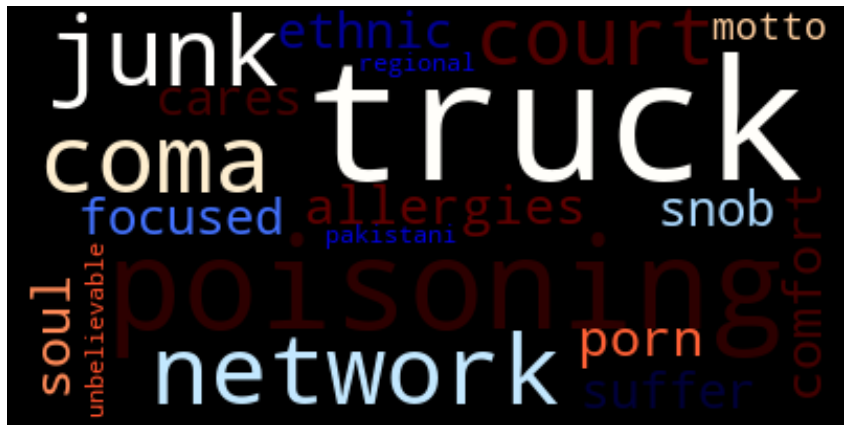

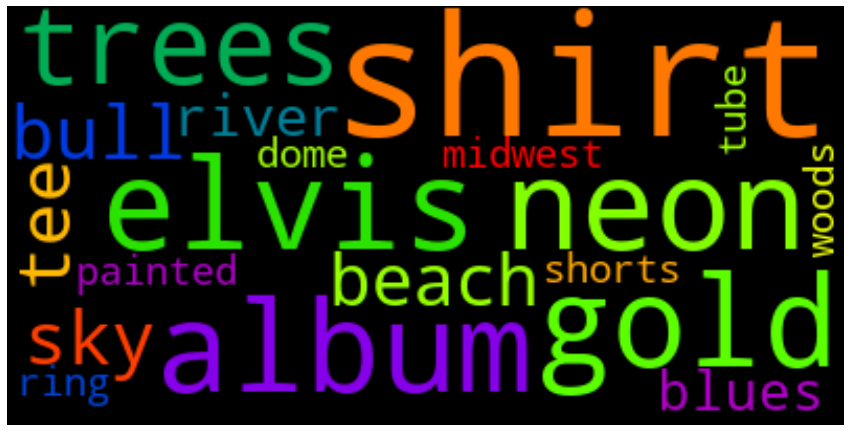

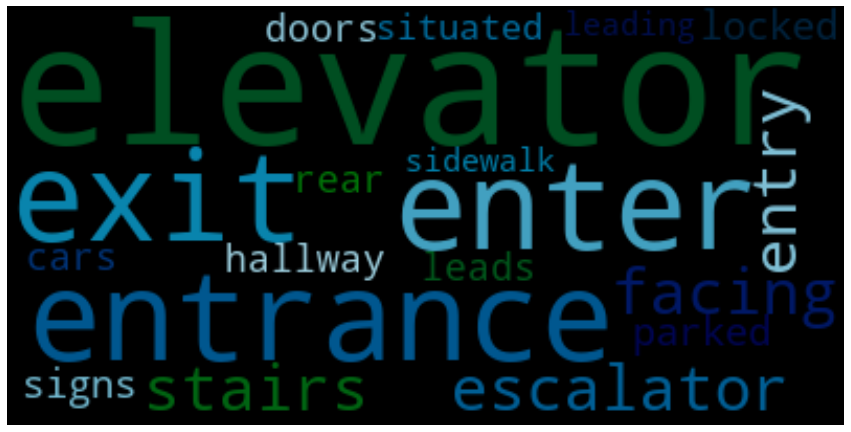

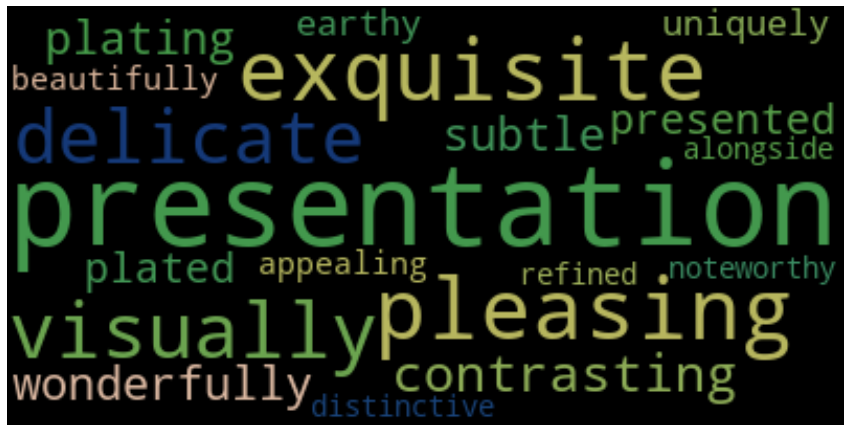

In [13]:
def display_cloud(cluster_index, color_map):
    logging.info("Printing word clouds for each cluster")
    if len(top_words['Cluster #' + str(cluster_index)])>0:
        wc = WordCloud(background_color="black", max_words=2000, max_font_size=80, colormap=color_map)
        wordcloud = wc.generate(' '.join([word for word in top_words['Cluster #' + str(cluster_index)]]))
        plt.subplots(1,1, figsize=(15, 15))
        plt.plot()
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
#         plt.savefig('clusters/cluster_' + str(self.wve_model.most_similar(positive=[self.cluster_centers[cluster_index]], topn=1)[0][0]), bbox_inches='tight')



cmaps = cycle([
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])
for i in range(4):
    col = next(cmaps);
    display_cloud(i, col)

plt.show()

In [14]:
logging.info("Saving cluster centroids")
output = {}
output['embedding_size'] = 256
output['num_clusters'] = 120
output['cluster_centers'] = cluster_centers.tolist()

with open('./cluster_data.json', 'w') as of_handle:
    json.dump(output, of_handle)
    of_handle.close()

In the next section, we process our review text into a form where for each review, we convert the review into its weighted centroid embedding form that was described earlier. This section of the code takes a considerable time to run.

In [44]:
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

class LSTMModelInput:
    def __init__(self):
        self.wve_model = gensim.models.Word2Vec.load('./wve.model')
        self.cluster_data_file_name = './cluster_data.json'
        self.dataset_location = './normalised_data.json'
        self.cluster_data = None
        self.useful_data = None
        self.tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
        self._stop_words_ = nltk.corpus.stopwords.words()
        self.clustering = joblib.load('./cluster.model')
        self.train_test_data_file_path = './train_test_data.json'
        logging.basicConfig(level=logging.INFO)

    def load_data(self):
        with open(self.cluster_data_file_name) as fh:
            self.cluster_data = json.load(fh)
            fh.close()

        with open(self.dataset_location, 'r') as fh:
            full_data = json.load(fh)
            self.useful_data = pd.DataFrame(json.loads(full_data['useful']))
            fh.close()

    def prepare_input(self):
        df = self.useful_data.sample(frac=1).reset_index(drop=True)
        text_input = df['text'].tolist()
        transformed_text = []
        cluster_count = []

        for _, review in enumerate(text_input):
            logging.info('Currently processing review %s:', review)
            no_tabs = str(review).replace('\t', ' ').replace('\n', '')
            alphas_only = re.sub("[^a-zA-Z\.]", " ", no_tabs)
            multi_spaces = re.sub(" +", " ", alphas_only)
            no_spaces = multi_spaces.strip()
            clean_text = no_spaces.lower()
            sentences = self.tokenizer.tokenize(clean_text)
            sentences = [re.sub("[\.]", "", sentence) for sentence in sentences]
            review_weights = range(self.cluster_data['num_clusters'])
            review_weights = dict(Counter(review_weights))
            review_weights = dict.fromkeys(review_weights, 0)

            if len(clean_text) > 0 and clean_text.count(' ') > 0:
                for sentence in sentences:
                    sentence = sentence.split(' ')
                    pruned_sentence = [self.get_cluster_bucket(word) for word in sentence if word not in self._stop_words_]

                    if len(pruned_sentence) > 0:
                        pruned_sentence = dict(Counter(pruned_sentence))
                        for key in review_weights:
                            if key in pruned_sentence:
                                review_weights[key] = review_weights[key] + pruned_sentence[key]
            
            sorted_review_weights = np.array([review_weights[key] for key in sorted(review_weights.keys())])
            final_weights = self.cluster_data['cluster_centers'] * sorted_review_weights[:, None]
            transformed_text.append(final_weights)
            cluster_count.append(sorted_review_weights)
        
        self.input_data = np.array(transformed_text)
        self.rf_input_data = np.array(cluster_count)
        self.labels = np.array(df['useful'].tolist())
        self.alternate_labels = np.array(df['useful_raw'].tolist())

    def get_cluster_bucket(self, word):
        if word in self.wve_model.wv.vocab:
            word_embedding = self.wve_model.wv[word]
            return self.clustering.predict([word_embedding])[0]
        else:
            return -1

    def save_training_data(self):
        rows, _ = self.useful_data.shape
        split_point = int(math.floor(rows * 0.7))
        train_input = self.input_data[0:split_point, :]
        test_input = self.input_data[split_point:rows, :]
        rf_train_input = self.rf_input_data[0:split_point, :]
        rf_test_input = self.rf_input_data[split_point: rows, :]
        train_labels = self.labels[0:split_point]
        test_labels = self.labels[split_point:rows]
        train_alternate_labels = self.alternate_labels[0:split_point]
        test_alternate_labels = self.alternate_labels[split_point:rows]
        
        class_labels_train = []
        for l in train_labels:
            if l < 0.33:
                class_labels_train.append('low')
            elif l >= 0.33 and l < 0.66:
                class_labels_train.append('medium')
            elif l >= 0.66 and l <= 1.0:
                class_labels_train.append('high')
        
        encoder_train = LabelEncoder()
        encoder_train.fit(class_labels_train)
        encoded_labels_train = encoder_train.transform(class_labels_train)
        # convert integers to dummy variables (i.e. one hot encoded)
        one_hot_labels_train = np_utils.to_categorical(encoded_labels_train)
        
        class_labels_test = []
        for l in test_labels:
            if l < 0.33:
                class_labels_test.append('low')
            elif l >= 0.33 and l < 0.66:
                class_labels_test.append('medium')
            elif l >= 0.66 and l <= 1.0:
                class_labels_test.append('high')

        encoder_test = LabelEncoder()
        encoder_test.fit(class_labels_test)
        encoded_labels_test = encoder_test.transform(class_labels_test)
        # convert integers to dummy variables (i.e. one hot encoded)
        one_hot_labels_test = np_utils.to_categorical(encoded_labels_test)
        
        oh_class_labels_train = []
        for l in train_labels:
            if l < 0.5:
                oh_class_labels_train.append('not useful')
            elif l >= 0.5:
                oh_class_labels_train.append('useful')
        
        oh_encoder_train = LabelEncoder()
        oh_encoder_train.fit(oh_class_labels_train)
        oh_encoded_labels_train = oh_encoder_train.transform(oh_class_labels_train)
        # convert integers to dummy variables (i.e. one hot encoded)
        oh_one_hot_labels_train = np_utils.to_categorical(oh_encoded_labels_train)
        
        oh_class_labels_test = []
        for l in test_labels:
            if l < 0.5:
                oh_class_labels_test.append('not useful')
            elif l >= 0.5:
                oh_class_labels_test.append('useful')

        oh_encoder_test = LabelEncoder()
        oh_encoder_test.fit(oh_class_labels_test)
        oh_encoded_labels_test = oh_encoder_test.transform(oh_class_labels_test)
        # convert integers to dummy variables (i.e. one hot encoded)
        oh_one_hot_labels_test = np_utils.to_categorical(oh_encoded_labels_test)
        
        return (train_input, test_input, train_labels, test_labels, one_hot_labels_train, one_hot_labels_test, rf_train_input, rf_test_input, oh_one_hot_labels_train, oh_one_hot_labels_test)

model = LSTMModelInput()
model.load_data()
model.prepare_input()
train_input, test_input, train_labels, test_labels, train_alternate_labels, test_alternate_labels, rf_train_input, rf_test_input, oh_train_labels, oh_test_labels = model.save_training_data()

Now that we have our input data and labels in the correct format, we will train a deep LSTM model to classify the data into one of three categories, wherein the values of 0 to 0.3 for 'useful', 'funny' and 'cool' fall into a class called 'low', the values for 0.3 to 0.6 fall into another class called 'medium' and finally the values for 0.6 to 1.0 fall into a class called 'high'. We thus hope to classify a given review as being low, medium or high in terms of 'usefulness', 'funnyness' or 'coolness'.

In [16]:
import tensorflow as tf
import json
import tensorflow.keras.backend as K
from keras.activations import softmax
import numpy as np
import logging

class LSTMModel:
    def __init__(self, train_data, test_data, train_labels, test_labels):
        logging.basicConfig(level=logging.INFO)
        self.model = None
        self.embedding_size = None
        self.num_clusters = None
        self.cluster_data_file_name = './cluster_data.json'
        self.train_data = train_data
        self.test_data = test_data
        self.train_labels = train_labels
        self.test_labels = test_labels
        self.read_data()
        self.create_model()
        self.train_model()
        self.calculate_accuracy()

    def create_model(self):
        logging.info('Creating Model')
        model = tf.keras.Sequential()
#         input_layer = tf.keras.layers.InputLayer(batch_size=128, input_shape=(self.num_clusters, self.embedding_size))
#         model.add(input_layer)

        dense_layer = tf.keras.layers.Dense(500, activation='relu', kernel_initializer='glorot_uniform', input_shape=(self.num_clusters, self.embedding_size))
        model.add(dense_layer)
        # dense_middle = tf.keras.layers.Dense(500, activation='tanh', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')
        # model.add(dense_middle)
        dense_layer_2 = tf.keras.layers.Dense(300, activation='relu')
        model.add(dense_layer_2)
        flatten_layer = tf.keras.layers.Flatten()
        model.add(flatten_layer)
        dense_layer_3 = tf.keras.layers.Dense(3, activation='softmax')
        model.add(dense_layer_3)

        model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), metrics = ['mse', 'mae'])
        self.model = model
        print(model.summary())

    def read_data(self):
        logging.info('Reading data')
        with open(self.cluster_data_file_name) as fh:
            data = json.load(fh)
            self.embedding_size = data['embedding_size']
            self.num_clusters = data['num_clusters']
            fh.close()
    
    def train_model(self):
        logging.info('Training Model')
        self.model.fit(self.train_data, self.train_labels, batch_size = 128, epochs = 5, validation_split = 0.3)

    def calculate_accuracy(self):
        predicted = self.model.predict(self.test_data)
        total = len(predicted)
        correct = 0
    
        for index, value in enumerate(predicted):
            if self.test_labels[index][np.argmax(value)] == 1:
                correct = correct + 1
        
        print("Final accuracy is %s", (correct/total))

lstm_model = LSTMModel(train_input, test_input, train_alternate_labels, test_alternate_labels)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 120, 500)          128500    
_________________________________________________________________
dense_1 (Dense)              (None, 120, 300)          150300    
_________________________________________________________________
flatten (Flatten)            (None, 36000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 108003    
Total params: 386,803
Trainable params: 386,803
Non-trainable params: 0
_________________________________________________________________
None
Train on 7443 samples, validate on 3190 samples
Epoch 1/5
7443/7443 [==============================] - 19s 3ms/sample - loss: 1.1895 - mean_squared_error: 0.2227 - mean_absolute_error: 0.4363 - val_loss: 1.0820 - val_mean_squared_error: 0.2187

As we can see above, we get a marginal improvement in accuracy. Next, we tried using a random forest to classify this data. Random forest is an ensemble method that consists of multiple decision trees. For this classifier, the input data is only the weights that are assigned to each of the cluster centers. For example, if I decide that the words: 'cook', 'bake' and 'fry' are going to be words that determine whether a review is useful or not, then for each review, I will look at each word within the review and determine which of the above three words it is closest to in terms of its word vector embedding. Let us say that my review contained three words that are closest to 'cook', four closest to 'bake' and 'one closest to 'fry'. My input to the network is then the array [3, 4, 1]. Again, we try to classify each review into one of three categories.

In [42]:
import logging
import json
import numpy as np
from sklearn.ensemble import RandomForestClassifier


class RandomForest:
    def __init__(self):
        logging.basicConfig(level=logging.INFO)
        self.cluster_data_file_name = './cluster_data.json'
        self.rf_train_data = rf_train_input
        self.train_labels = train_alternate_labels
        self.rf_test_data = rf_test_input
        self.test_labels = test_alternate_labels
        
        self.train_model()
        self.calculate_accuracy()

    def train_model(self):
        logging.info('Training Model')
        self.regressor = RandomForestClassifier(n_estimators=100, random_state=0)
        self.regressor.fit(self.rf_train_data, self.train_labels)
    
    def calculate_accuracy(self):
        logging.info('Predicting')
        predictions = self.regressor.predict(self.rf_test_data)
        correct = 0
        total = len(self.test_labels)

        for index, prediction in enumerate(predictions):
            if self.test_labels[index][np.argmax(prediction)] == 1:
                correct = correct + 1
        
        accuracy = correct/total
        print('Final accuracy is ' + str(accuracy))

model = RandomForest()

Final accuracy is 0.3833662497256967


As we can see, this model does not perform much better than the previous model. Therefore, we will rephrase our classification task as a binary classification task wherein we either determine if a review is 'useful', 'funny' and 'cool' or it is 'not useful', 'not funny' and 'not cool'. Therefore, any values for the 'useful', 'funny' and 'cool' columns that fall into the range of 0 to 0.5 are treated as not useful and any values in the range of 0.5 to 1 are treated as useful.

In [45]:
import logging
import json
import numpy as np
from sklearn.ensemble import RandomForestClassifier


class RandomForest:
    def __init__(self):
        logging.basicConfig(level=logging.INFO)
        self.cluster_data_file_name = './cluster_data.json'
        self.rf_train_data = rf_train_input
        self.train_labels = oh_train_labels
        self.rf_test_data = rf_test_input
        self.test_labels = oh_test_labels
        
        self.train_model()
        self.calculate_accuracy()

    def train_model(self):
        logging.info('Training Model')
        self.regressor = RandomForestClassifier(n_estimators=100, random_state=0)
        self.regressor.fit(self.rf_train_data, self.train_labels)
    
    def calculate_accuracy(self):
        logging.info('Predicting')
        predictions = self.regressor.predict(self.rf_test_data)
        correct = 0
        total = len(self.test_labels)

        for index, prediction in enumerate(predictions):
            if self.test_labels[index][np.argmax(prediction)] == 1:
                correct = correct + 1
        
        accuracy = correct/total
        print('Final accuracy is ' + str(accuracy))

model = RandomForest()

Final accuracy is 0.5887645380732939


We see that the accuracy has increase significantly which is expected because we reduced the dimensionality of the output classifications. We can try the same classification task with the deep learning network to see whether the deep learning network improves the accuracy of the binary classification task. However, we do not expect to see a significant improvement using this network.

In [47]:
import tensorflow as tf
import json
import tensorflow.keras.backend as K
from keras.activations import softmax
import numpy as np
import logging

class LSTMModel:
    def __init__(self, train_data, test_data, train_labels, test_labels):
        logging.basicConfig(level=logging.INFO)
        self.model = None
        self.embedding_size = None
        self.num_clusters = None
        self.cluster_data_file_name = './cluster_data.json'
        self.train_data = train_data
        self.test_data = test_data
        self.train_labels = train_labels
        self.test_labels = test_labels
        self.read_data()
        self.create_model()
        self.train_model()
        self.calculate_accuracy()

    def create_model(self):
        logging.info('Creating Model')
        model = tf.keras.Sequential()
#         input_layer = tf.keras.layers.InputLayer(batch_size=128, input_shape=(self.num_clusters, self.embedding_size))
#         model.add(input_layer)

        dense_layer = tf.keras.layers.Dense(500, activation='relu', kernel_initializer='glorot_uniform', input_shape=(self.num_clusters, self.embedding_size))
        model.add(dense_layer)
        # dense_middle = tf.keras.layers.Dense(500, activation='tanh', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')
        # model.add(dense_middle)
        dense_layer_2 = tf.keras.layers.Dense(300, activation='relu')
        model.add(dense_layer_2)
        flatten_layer = tf.keras.layers.Flatten()
        model.add(flatten_layer)
        dense_layer_3 = tf.keras.layers.Dense(2, activation='softmax')
        model.add(dense_layer_3)

        model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), metrics = ['mse', 'mae'])
        self.model = model
        print(model.summary())

    def read_data(self):
        logging.info('Reading data')
        with open(self.cluster_data_file_name) as fh:
            data = json.load(fh)
            self.embedding_size = data['embedding_size']
            self.num_clusters = data['num_clusters']
            fh.close()
    
    def train_model(self):
        logging.info('Training Model')
        self.model.fit(self.train_data, self.train_labels, batch_size = 128, epochs = 5, validation_split = 0.3)

    def calculate_accuracy(self):
        predicted = self.model.predict(self.test_data)
        total = len(predicted)
        correct = 0
    
        for index, value in enumerate(predicted):
            if self.test_labels[index][np.argmax(value)] == 1:
                correct = correct + 1
        
        print("Final accuracy is %s", (correct/total))

lstm_model = LSTMModel(train_input, test_input, oh_train_labels, oh_test_labels)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 120, 500)          128500    
_________________________________________________________________
dense_7 (Dense)              (None, 120, 300)          150300    
_________________________________________________________________
flatten_2 (Flatten)          (None, 36000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 72002     
Total params: 350,802
Trainable params: 350,802
Non-trainable params: 0
_________________________________________________________________
None
Train on 7443 samples, validate on 3190 samples
Epoch 1/5
7443/7443 [==============================] - 17s 2ms/sample - loss: 0.7893 - mean_squared_error: 0.2539 - mean_absolute_error: 0.4895 - val_loss: 0.6794 - val_mean_squared_error: 0.24

As expected, this model provides a similar accuracy to the previous one.

## Conclusion:

In this project, we set out to create a model which can help Yelp in determining how useful, funny or cool a new review is. To start off, we tried to frame this as a regression task wherein we determine the usefulness, funnyness or coolness of a review on a scale of 0 to 1, 0 being not useful and 1 being very useful. However, we soon learnt that this was not feasible and we had to reframe our problem as a classification task. On running various models to classify each review, we have come to the conclusion that due to some inherent bias's present in the review data, it is difficult to model a good estimator for how useful, funny or cool a given review is. This happens due to various factors, some of which are explained below:

* Two review that are equalliy similar in terms of content and length have vastly different counts for 'useful' and 'funny' within the training data. This might be due to the fact that some restaurants are located in more populated areas and as a result have a larger number of upvotes on their reviews.
* Some reviews which are quite useful, funny, or cool simply do not have many upvotes. This could be due to the fact that they were not online for a large amount of time before the data was harvested or simply because the restaurant does not get many visitors and thus does not get many upvotes on google.
* Usefulness, funnyness and coolness are subjective criteria by which one measures the quality of a review. What one person or demographic finds as useful might not be useful at all in another demographic. From my personal experience of using Yelp back home in London, it was quite important for me to see the proximity of a certain restaurant to a local train station or underground station in London. I would consider a review that mentions such details as more useful than one that does not simply because public transport is the most widely used form of transport in London.However, when reading through reviews in LA for example, the proximity of the restaurant to public transport is not important to me at all. Such bias's are hard to capture in the text data alone.